In [1]:
import pandas as pd 
import numpy as np 
import seaborn as sns
import matplotlib.pyplot as plt 
%matplotlib inline 

from datetime import datetime
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error

import seaborn as sns
#sns.set(rc={"axes.facecolor":"Beige" , "axes.grid" : False})
plt.rcParams["figure.figsize"] = (20, 6)
params = {'axes.labelsize': 18, 'axes.titlesize': 22, 'font.size': 17}
plt.rcParams.update(params)

import warnings
warnings.filterwarnings("ignore")

In [2]:
df = pd.read_csv("/kaggle/input/electricity-consumption-and-meteorology-in-sceaux/final_dataset.csv")
df = df.fillna(method = 'ffill')
df['time'] = pd.to_datetime(df['time'])
df.head(2) 

time  Global_active_power  Global_reactive_power     Voltage  \
0 2007-01-01 00:00:00             2.537017               0.092217  241.228917   
1 2007-01-01 02:00:00             2.562000               0.098383  243.232917   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
0         10.486667             0.0        0.291667             0.0   
1         10.470000             0.0        0.300000             0.0   

   Precipitation  CloudCover  Temperature  Snowfall      Wind  
0   1.329846e-07    0.999695    286.43298       0.0  9.663516  
1   2.353721e-07    0.556274    285.98602       0.0  8.988889

In [3]:
df1 = df.copy('Deep')

df1 = df1.rename(columns = {'time' : 'Datetime'})

df1 = df1.set_index('Datetime')
df1.index = pd.to_datetime(df1.index,infer_datetime_format = True)
df1.head()

Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                                      
2007-01-01 00:00:00             2.537017               0.092217  241.228917   
2007-01-01 02:00:00             2.562000               0.098383  243.232917   
2007-01-01 04:00:00             2.475983               0.094917  242.402417   
2007-01-01 06:00:00             2.451500               0.096500  240.768000   
2007-01-01 08:00:00             2.793933               0.072850  240.461000   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2007-01-01 00:00:00         10.486667             0.0        0.291667   
2007-01-01 02:00:00         10.470000             0.0        0.300000   
2007-01-01 04:00:00         10.130000             0.0        0.291667   
2007-01-01 06:00:00         10.111667             0.0        0.275000   
2007-01-01 08:00:00         11.550000             0.0        0.025000   

                     Sub_metering_3  Precipitation  CloudCover  Temperature  \
Datetime                                                                      
2007-01-01 00:00:00        0.000000   1.329846e-07    0.999695    286.43298   
2007-01-01 02:00:00        0.000000   2.353721e-07    0.556274    285.98602   
2007-01-01 04:00:00        0.000000   3.708734e-09    0.164459    284.50214   
2007-01-01 06:00:00        0.000000   0.000000e+00    0.197144    283.30905   
2007-01-01 08:00:00        6.016667   2.053049e-08    0.172791    282.31317   

                     Snowfall      Wind  
Datetime                                 
2007-01-01 00:00:00       0.0  9.663516  
2007-01-01 02:00:00       0.0  8.988889  
2007-01-01 04:00:00       0.0  6.604268  
2007-01-01 06:00:00       0.0  7.486063  
2007-01-01 08:00:00       0.0  8.071110

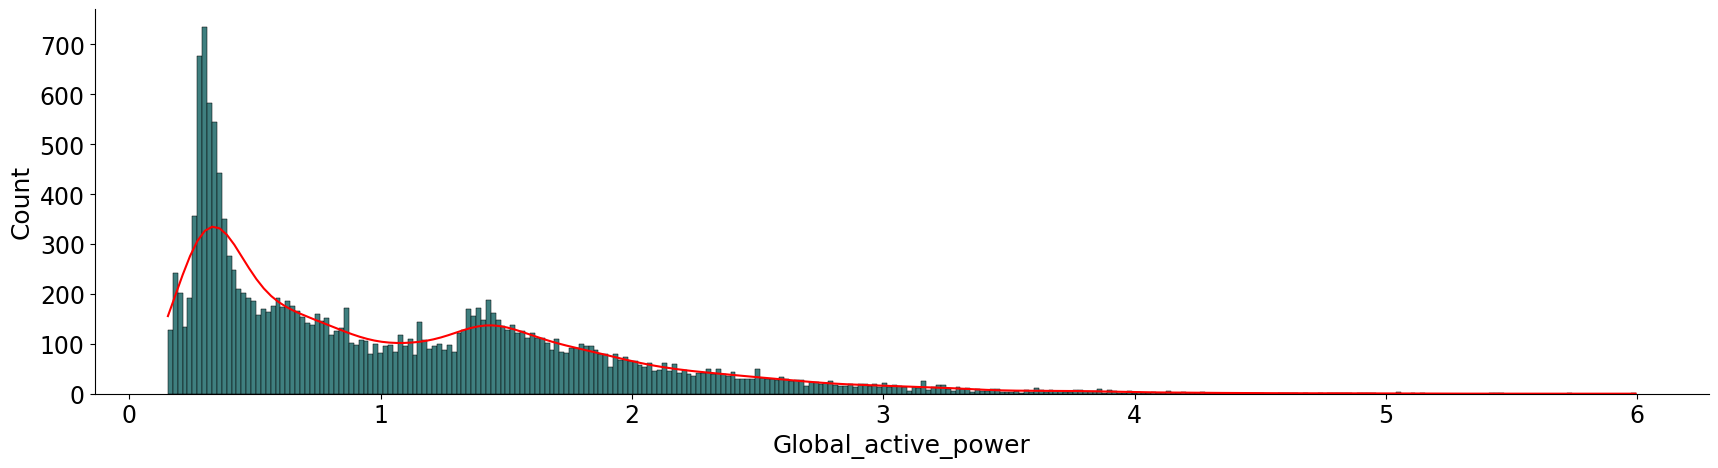

In [4]:
sns.displot(data=df1, x="Global_active_power", kde=True, bins = 300,color = "red", facecolor = "#3F7F7F",height = 5, aspect = 3.5);

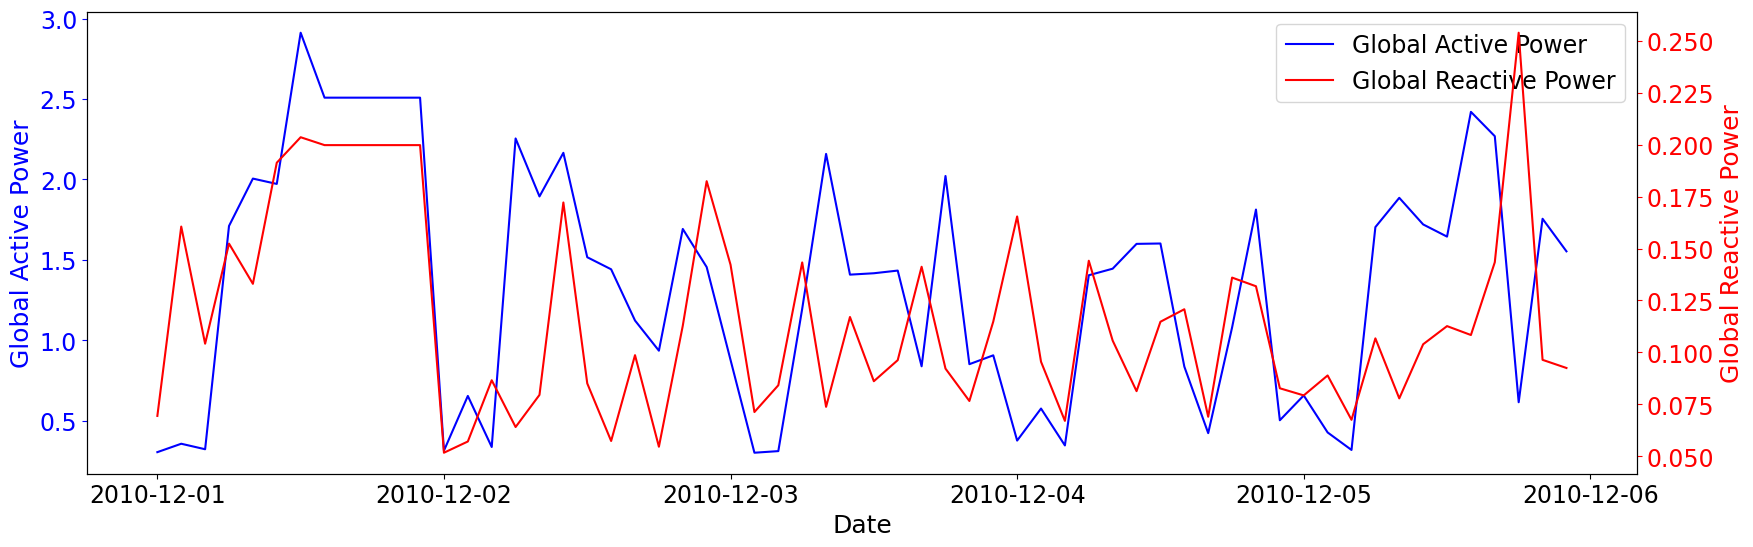

In [5]:
df2 = df1.copy('Deep')

dfx = df2[["Global_active_power", "Global_reactive_power"]]["2010-12-01" : "2010-12-05 "]

fig, ax1 = plt.subplots(figsize=(20,6))
ax1.plot(dfx.index, dfx['Global_active_power'], 'b', label='Global Active Power')
ax1.set_xlabel('Date')
ax1.set_ylabel('Global Active Power', color='b')
ax1.tick_params('y', colors='b')

ax2 = ax1.twinx()

ax2.plot(dfx.index, dfx['Global_reactive_power'], 'r', label='Global Reactive Power')
ax2.set_ylabel('Global Reactive Power', color='r')
ax2.tick_params('y', colors='r')

lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
lines = lines1 + lines2
labels = labels1 + labels2
ax1.legend(lines, labels, loc='upper right')
plt.show()

Train:	 14595
Test:	 2700


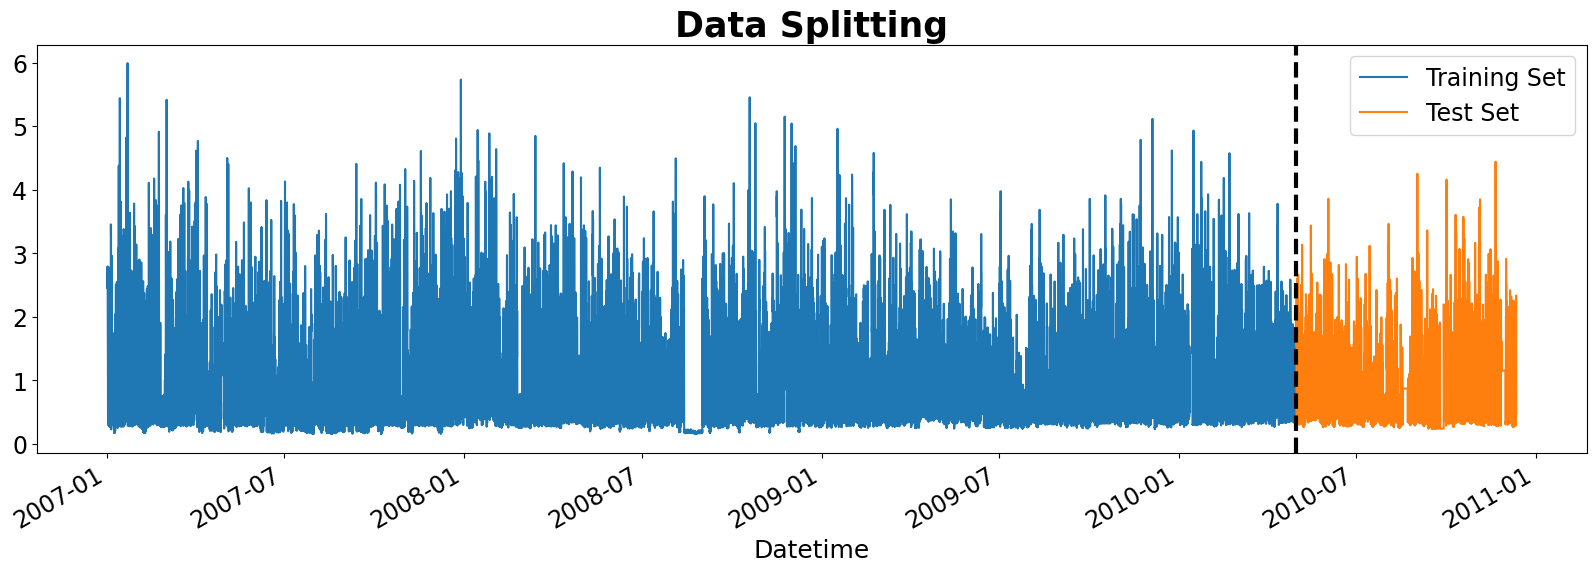

In [6]:
# Before building and training our model, let's split the data into training and testing
train, test = df2[df2.index < '2010-05-01'], df2[df2.index >= '2010-05-01']

print('Train:\t', len(train))
print('Test:\t', len(test))

plt.figure(figsize=(20,6))

train['Global_active_power'].plot(label='Training Set')
test['Global_active_power'].plot(label='Test Set');
plt.axvline('2010-05-01', color='black', ls='--', lw=3)
plt.title('Data Splitting', weight='bold', fontsize=25)
plt.legend();

In [7]:
def create_features(df):
    '''create time series features from the index '''
    
    df['hour'] = df.index.hour
    df['day_of_week'] = df.index.dayofweek
    df['quarter'] = df.index.quarter
    df['month'] = df.index.month
    df['day_of_month'] = df.index.day
    df['day_of_year'] = df.index.dayofyear
    df['week_of_year'] = df.index.isocalendar().week
    
    return df
create_features(df2)

Global_active_power  Global_reactive_power     Voltage  \
Datetime                                                                      
2007-01-01 00:00:00             2.537017               0.092217  241.228917   
2007-01-01 02:00:00             2.562000               0.098383  243.232917   
2007-01-01 04:00:00             2.475983               0.094917  242.402417   
2007-01-01 06:00:00             2.451500               0.096500  240.768000   
2007-01-01 08:00:00             2.793933               0.072850  240.461000   
...                                  ...                    ...         ...   
2010-12-11 14:00:00             1.555850               0.168850  236.979333   
2010-12-11 16:00:00             1.908883               0.191567  233.290500   
2010-12-11 18:00:00             2.336417               0.105783  231.377417   
2010-12-11 20:00:00             1.434117               0.085317  235.275583   
2010-12-11 22:00:00             0.480200               0.063000  241.756083   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2007-01-01 00:00:00         10.486667           0.000        0.291667   
2007-01-01 02:00:00         10.470000           0.000        0.300000   
2007-01-01 04:00:00         10.130000           0.000        0.291667   
2007-01-01 06:00:00         10.111667           0.000        0.275000   
2007-01-01 08:00:00         11.550000           0.000        0.025000   
...                               ...             ...             ...   
2010-12-11 14:00:00          6.818333           0.000        0.258333   
2010-12-11 16:00:00          8.260000           0.000        0.608333   
2010-12-11 18:00:00         10.098333           0.175        0.000000   
2010-12-11 20:00:00          6.123333           8.300        0.775000   
2010-12-11 22:00:00          1.990000           0.000        0.000000   

                     Sub_metering_3  Precipitation  CloudCover  Temperature  \
Datetime                                                                      
2007-01-01 00:00:00        0.000000   1.329846e-07    0.999695    286.43298   
2007-01-01 02:00:00        0.000000   2.353721e-07    0.556274    285.98602   
2007-01-01 04:00:00        0.000000   3.708734e-09    0.164459    284.50214   
2007-01-01 06:00:00        0.000000   0.000000e+00    0.197144    283.30905   
2007-01-01 08:00:00        6.016667   2.053049e-08    0.172791    282.31317   
...                             ...            ...         ...          ...   
2010-12-11 14:00:00       10.625000   0.000000e+00    1.000000    278.62927   
2010-12-11 16:00:00        5.958333   1.589457e-09    1.000000    278.68933   
2010-12-11 18:00:00        6.566667   1.298057e-08    1.000000    278.19742   
2010-12-11 20:00:00        5.033333   2.516640e-09    0.998108    277.87292   
2010-12-11 22:00:00        0.000000   1.986822e-09    0.907837    277.96870   

                     Snowfall      Wind  hour  day_of_week  quarter  month  \
Datetime                                                                     
2007-01-01 00:00:00       0.0  9.663516     0            0        1      1   
2007-01-01 02:00:00       0.0  8.988889     2            0        1      1   
2007-01-01 04:00:00       0.0  6.604268     4            0        1      1   
2007-01-01 06:00:00       0.0  7.486063     6            0        1      1   
2007-01-01 08:00:00       0.0  8.071110     8            0        1      1   
...                       ...       ...   ...          ...      ...    ...   
2010-12-11 14:00:00       0.0  1.694674    14            5        4     12   
2010-12-11 16:00:00       0.0  0.930473    16            5        4     12   
2010-12-11 18:00:00       0.0  0.700579    18            5        4     12   
2010-12-11 20:00:00       0.0  0.899321    20            5        4     12   
2010-12-11 22:00:00       0.0  1.093261    22            5        4     12   



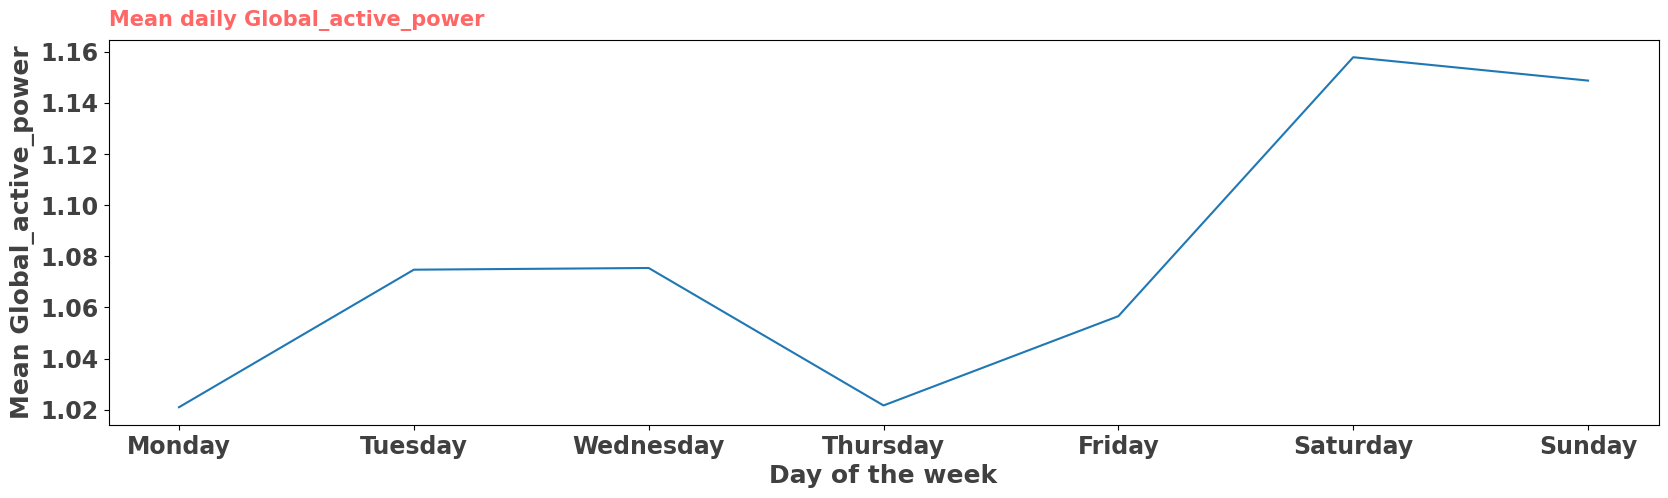

In [8]:
mean_per_day = df2.groupby("day_of_week")["Global_active_power"].agg(["mean"])

fig, ax = plt.subplots(figsize=(20,5))
plt.plot(mean_per_day.index,mean_per_day["mean"])

plt.xticks(mean_per_day.index, ["Monday","Tuesday", "Wednesday", "Thursday", "Friday", "Saturday","Sunday"], alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")
plt.xlabel("Day of the week",alpha=0.75, weight="bold")
plt.ylabel("Mean Global_active_power",alpha=0.75, weight="bold")
plt.title("Mean daily Global_active_power", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10,color='Red');
del mean_per_day

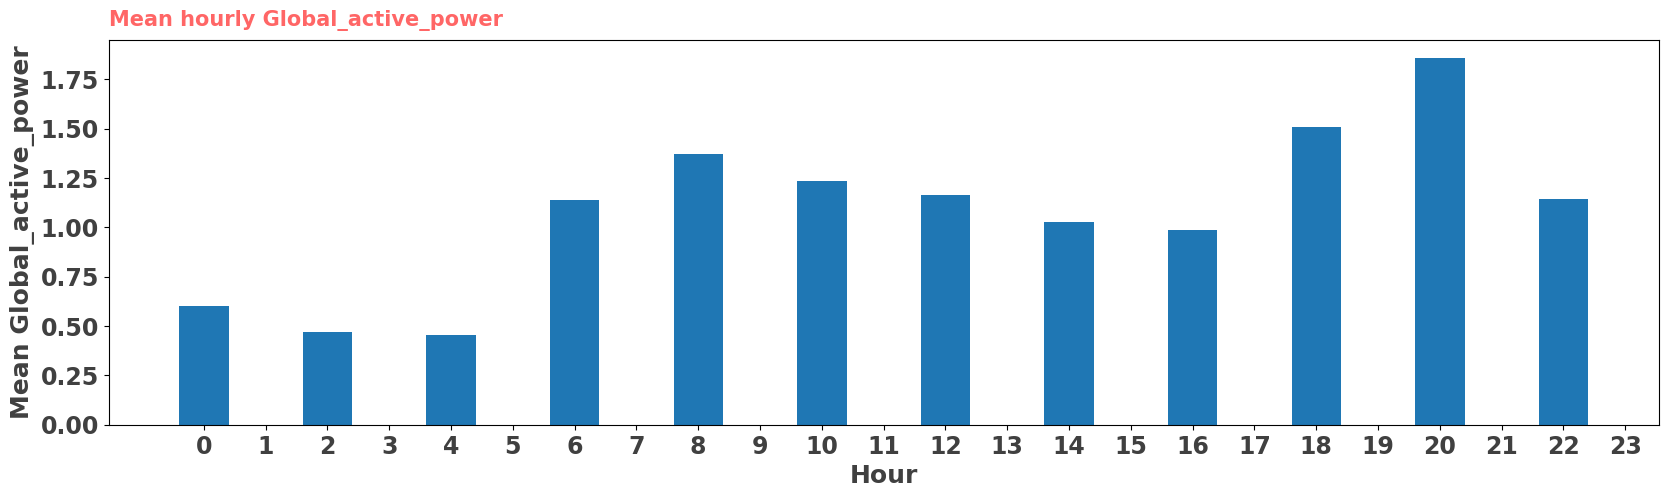

In [9]:
mean_per_hour = df2.groupby("hour")["Global_active_power"].agg(["mean"])

fig, ax = plt.subplots(figsize=(20,5))

plt.bar(mean_per_hour.index, mean_per_hour["mean"])

plt.xticks(range(24),alpha=0.75, weight="bold")
plt.yticks(alpha=0.75, weight="bold")
plt.xlabel("Hour",alpha=0.75, weight="bold")
plt.ylabel("Mean Global_active_power",alpha=0.75, weight="bold")
plt.title("Mean hourly Global_active_power", alpha=0.60, weight="bold", fontsize=15, loc="left", pad=10,color="Red")

del mean_per_hour


In [10]:
import plotly.express as px
import plotly.graph_objects as go
fig = px.box(df2, x='hour', y='Global_active_power', title='Hourly Global_active_power Patterns')
fig.show()

In [11]:
fig = px.box(df2, x='day_of_week', y='Global_active_power', title='weekly Global_active_power Patterns')
fig.show()

In [12]:
fig = px.box(df2, x='month', y='Global_active_power', title='Monthly Global_active_power Patterns')
fig.show()

In [13]:
import pandas as pd
import plotly.express as px

# Assuming your data is in a DataFrame named 'df2'

# Group data by day of week and hour, calculate mean of 'Global_active_power', reset index
hourly_avg = df2.groupby(['day_of_week', 'hour']).mean()['Global_active_power'].reset_index()

# Create pivot table with day of week as rows and hour as columns
hourly_avg = hourly_avg.pivot_table(index='day_of_week', columns='hour', values='Global_active_power')

# Create heatmap using px.imshow
fig = px.imshow(hourly_avg,
                 labels=dict(x="Hour of Day", y="Day of Week", color="Avg Consumption"),
                 # No explicit x needed as labels are inferred from column names
                 y=['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday'],
                 title='Average Hourly Global_active_power Heatmap')

# Display the heatmap
fig.show()


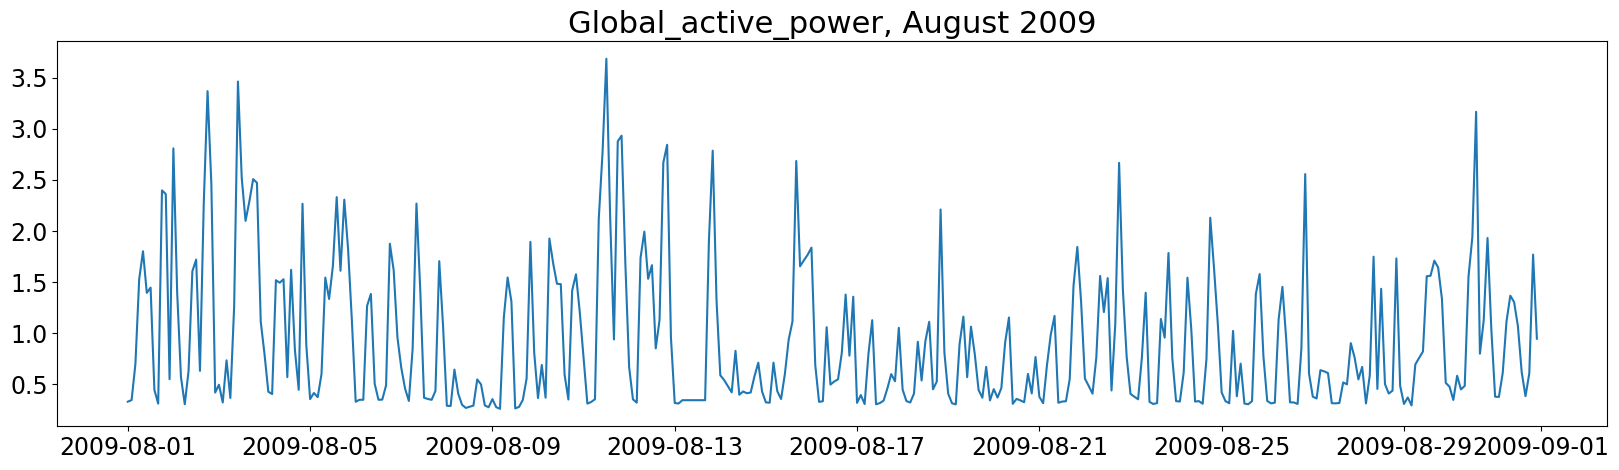

In [14]:
plt.figure(figsize=(20,5))
plt.plot(df2[(df2.index.year==2009) & (df2.index.month==8)]['Global_active_power'])
plt.title('Global_active_power, August 2009')
plt.show()

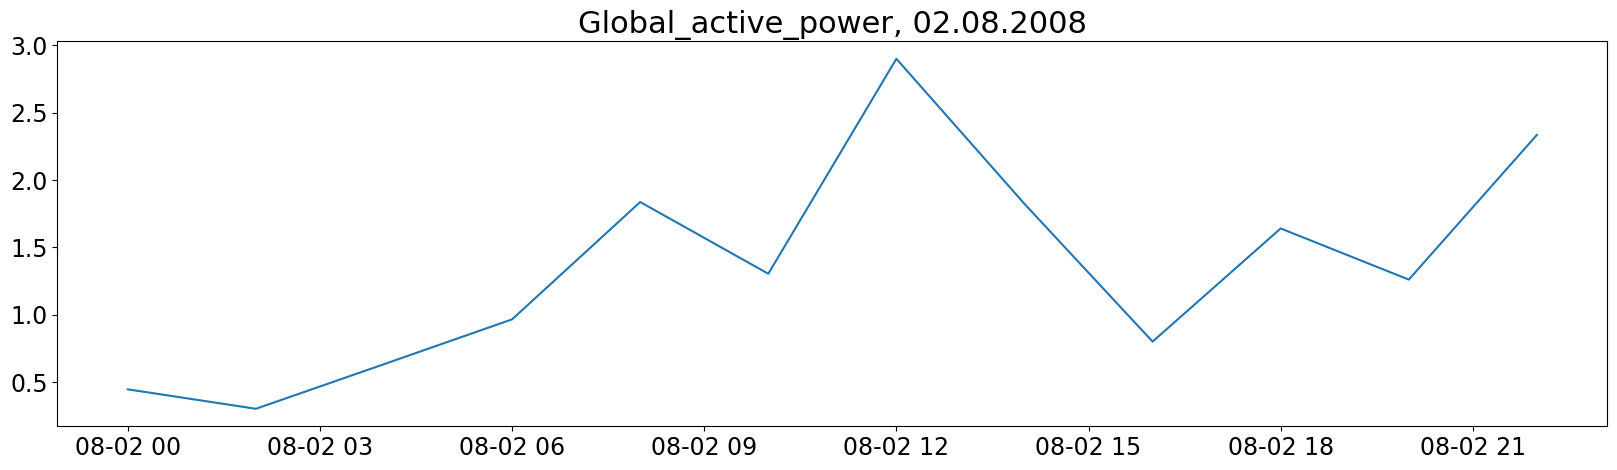

In [15]:
plt.figure(figsize=(20,5))
plt.plot(df2[(df2.index.year==2008) & (df2.index.month==8) & (df2.index.day==2)]['Global_active_power'])
plt.title('Global_active_power, 02.08.2008')
plt.show()

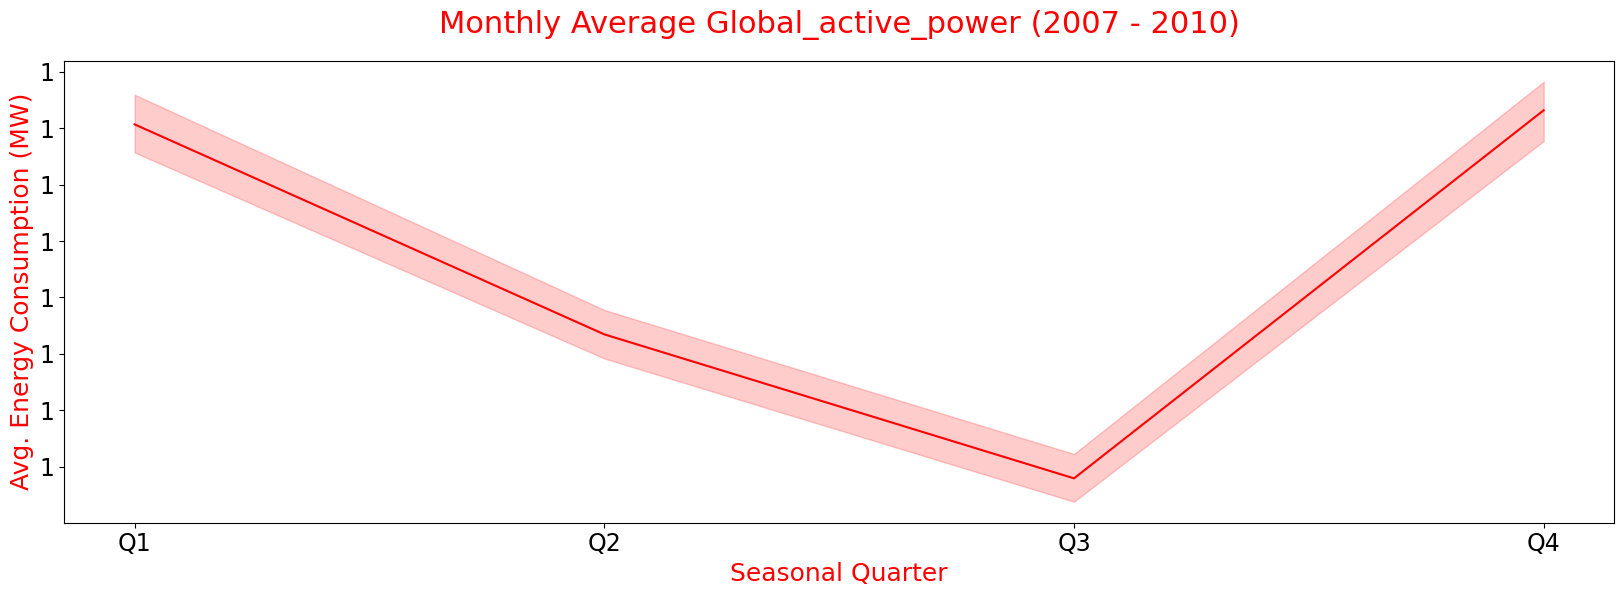

In [16]:
from matplotlib import ticker
fig, ax = plt.subplots(figsize=(20,6))
sns.lineplot(ax=ax, data=df2, x='quarter', y='Global_active_power', ci=95,color="red")
ax.yaxis.set_major_formatter(ticker.StrMethodFormatter('{x:,.0f}'))
ax.set_xticks([1,2,3,4])
ax.set_xticklabels(['Q1', 'Q2', 'Q3', 'Q4'])
ax.set_ylabel('Avg. Energy Consumption (MW)',color="red")
ax.set_xlabel('Seasonal Quarter',color='Red')
ax.set_title('Monthly Average Global_active_power (2007 - 2010)',color='Red',pad=20)
plt.show()

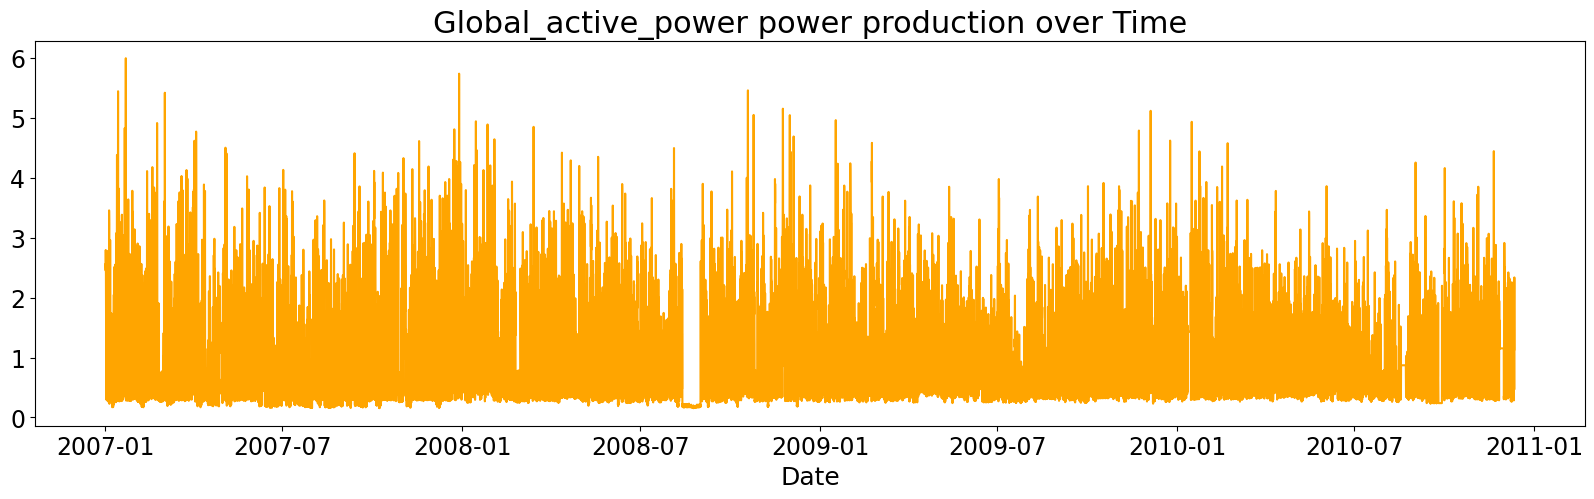

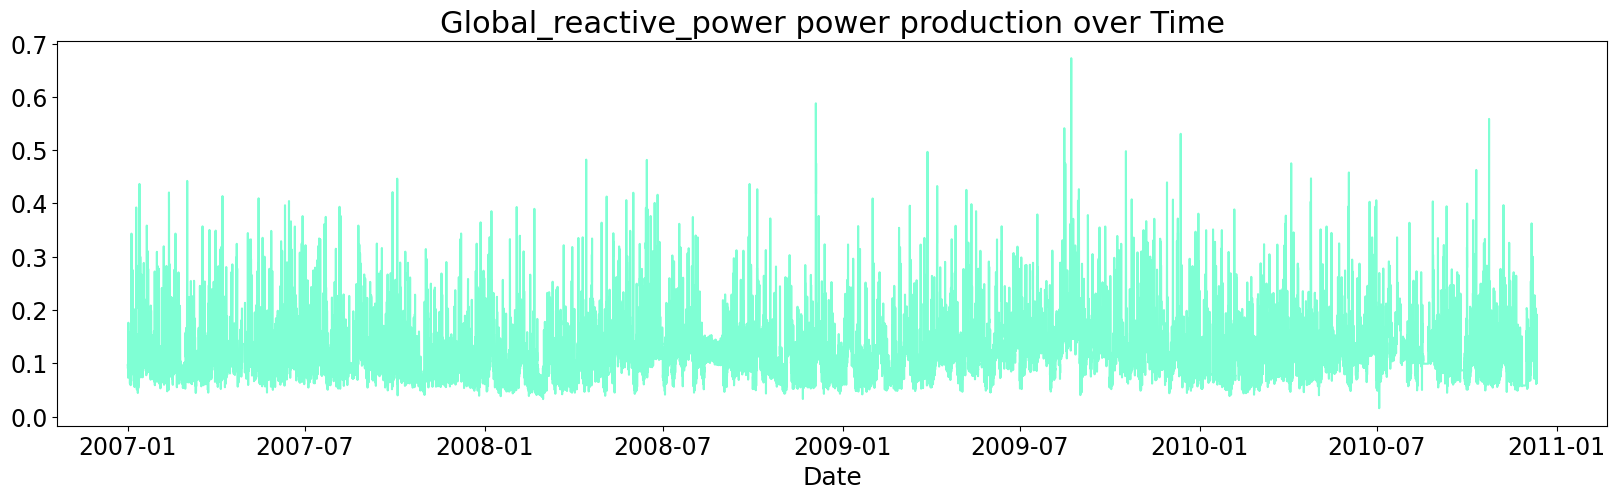

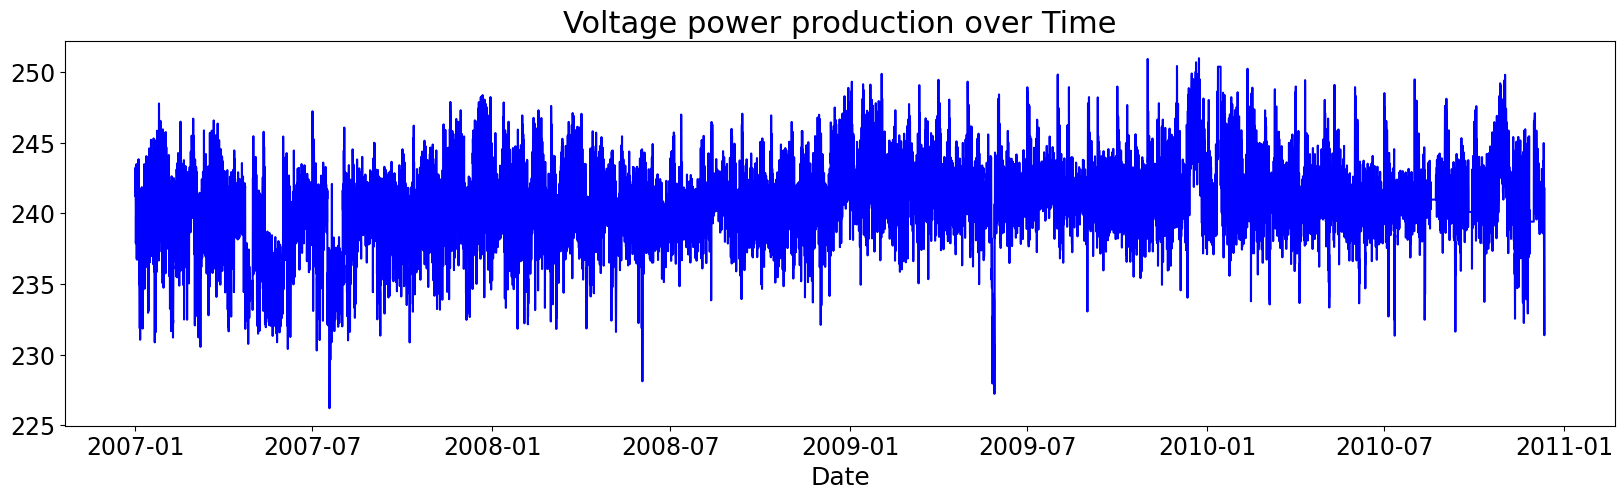

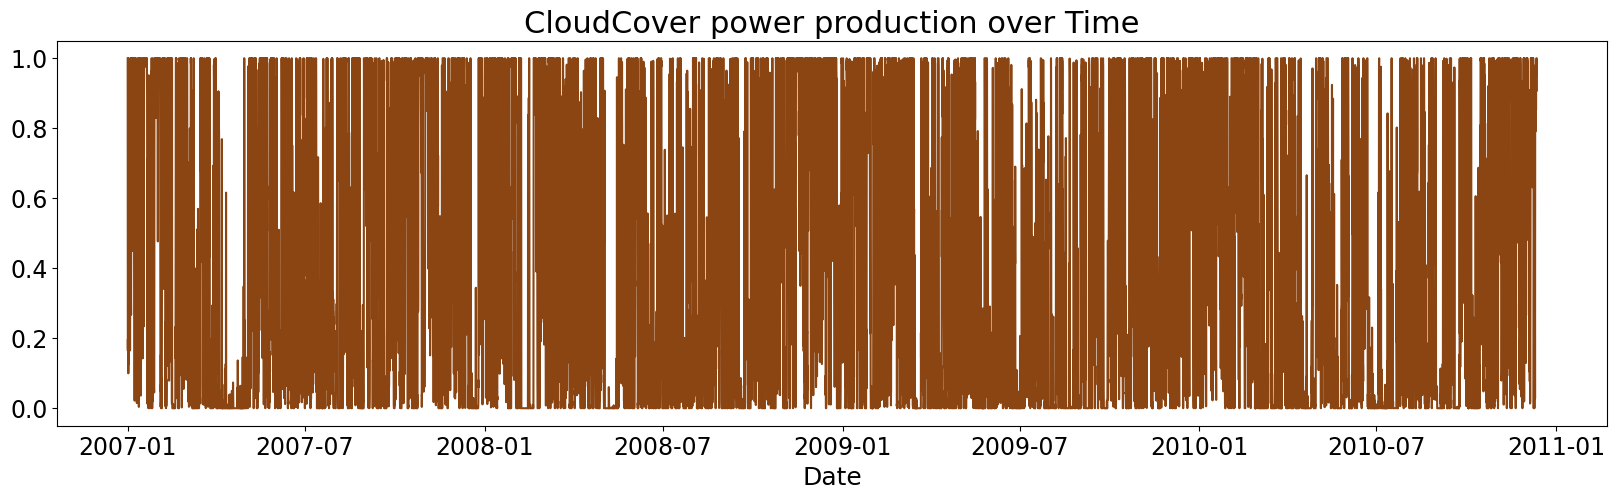

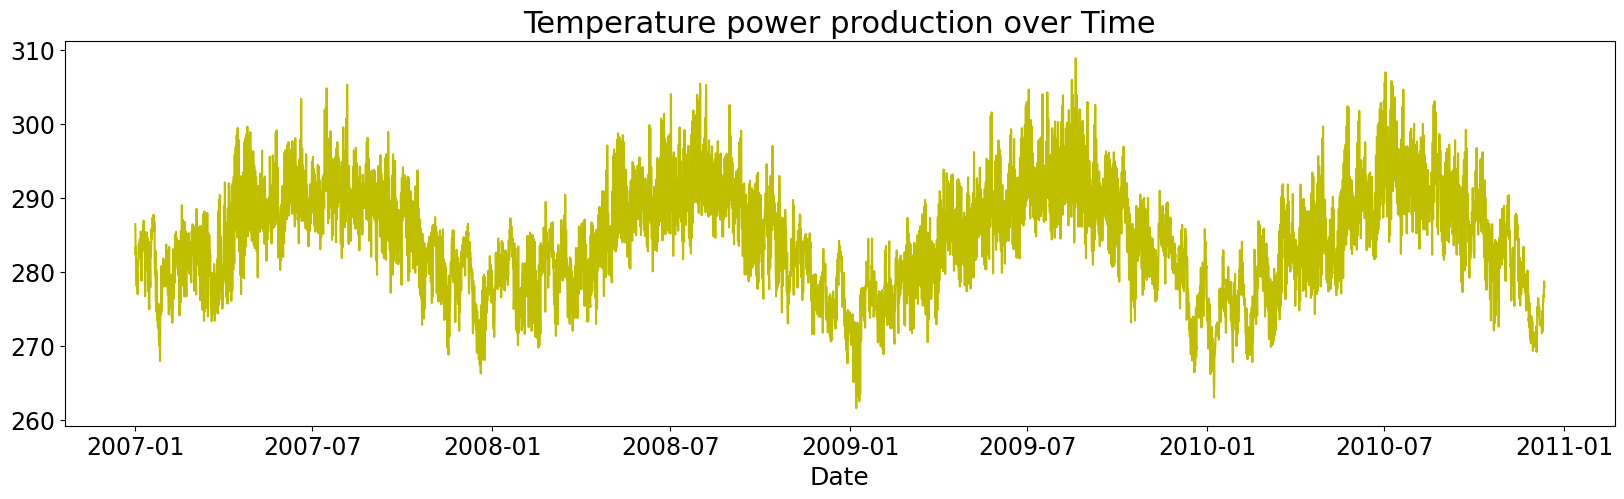

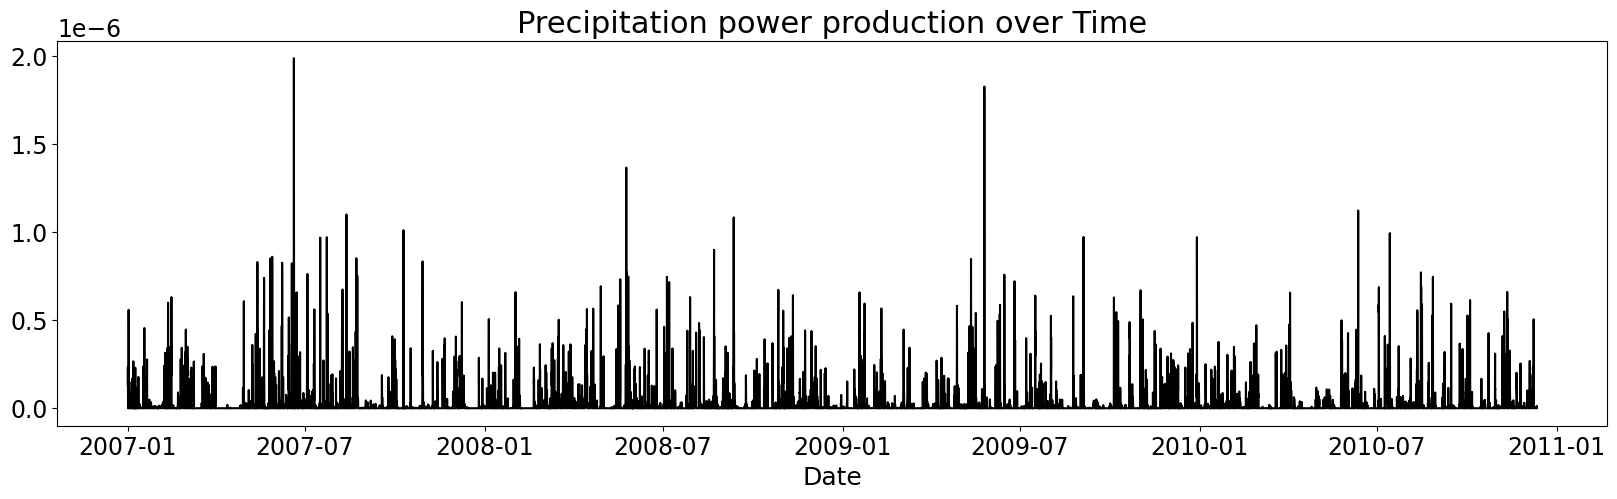

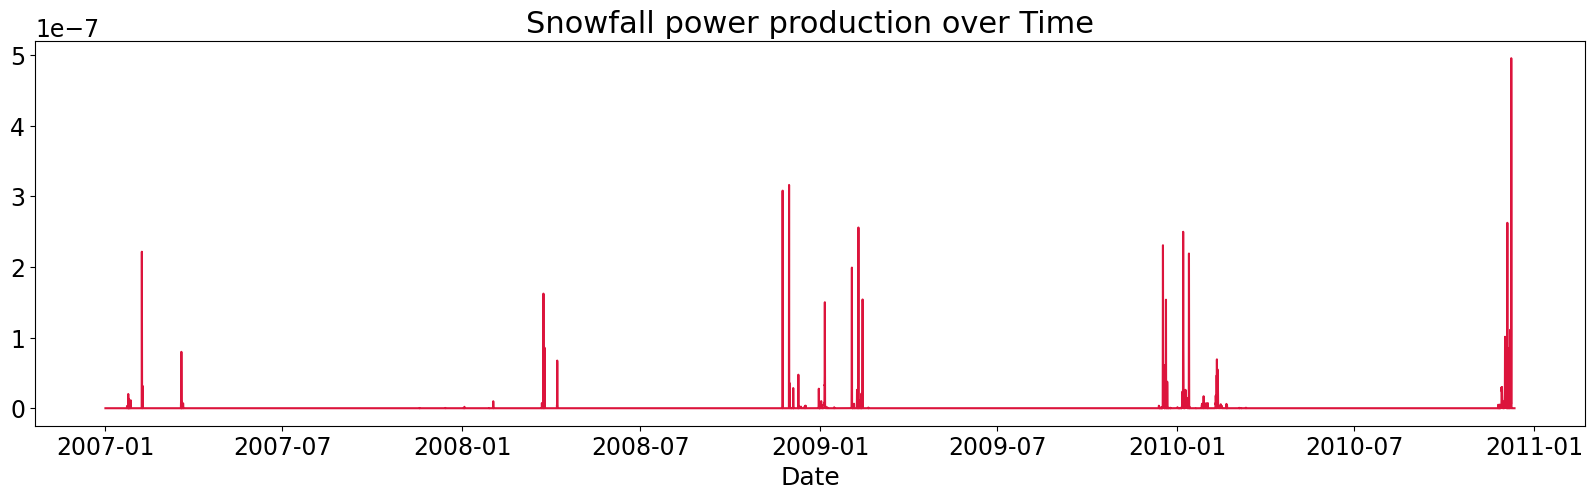

In [17]:
Types =['Global_active_power','Global_reactive_power','Voltage','CloudCover','Temperature','Precipitation','Snowfall']

colors = {'Global_active_power':'orange', 'Global_reactive_power':'aquamarine', 'Voltage':'b', 'CloudCover':'saddlebrown', 'Precipitation':'black', 'Temperature':'y', 'Snowfall':'crimson'}
for prType in Types:
    plt.figure(figsize=(20,5))
    plt.plot(df2.index, df2[prType], color=colors.get(prType))
    plt.title(f'{prType} power production over Time')
    plt.xlabel('Date')
    plt.ylabel('')
    plt.show()

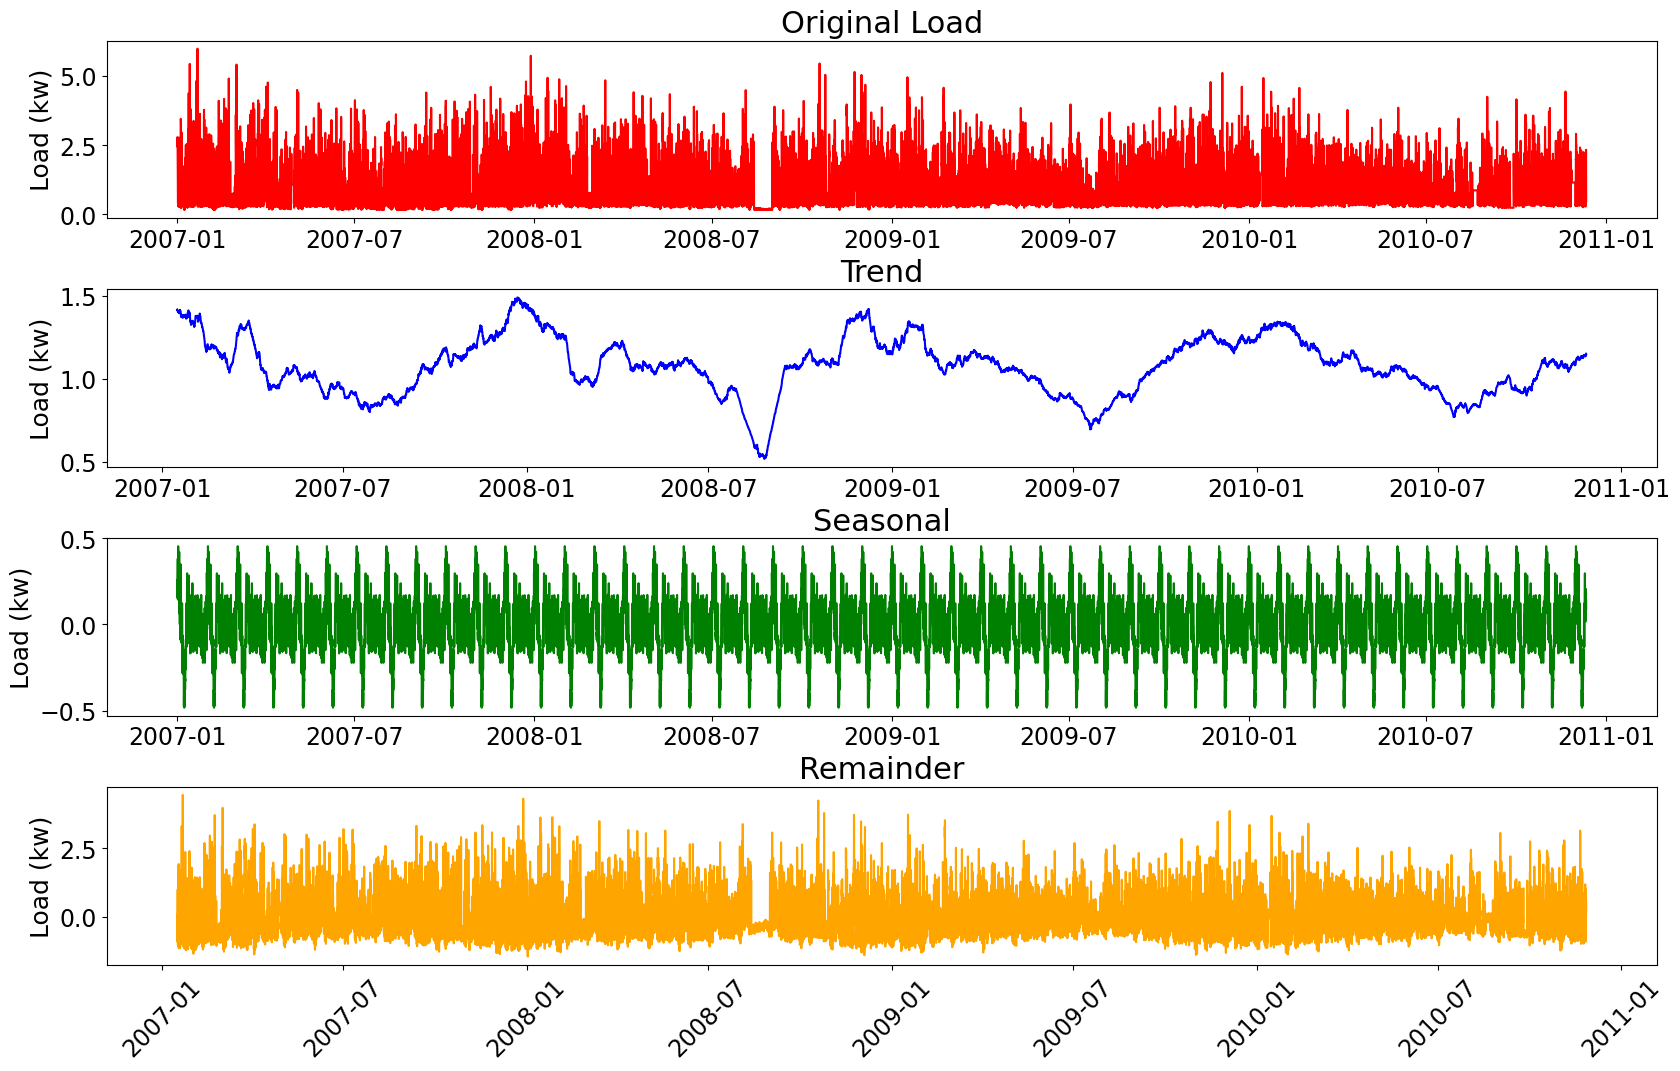

In [18]:
from statsmodels.tsa.seasonal import seasonal_decompose

df3 = df2[['Global_active_power']]
# Decompose the data
decomposition = seasonal_decompose(df3, period=365)

# Extract components
trend = decomposition.trend
seasonal = decomposition.seasonal
remainder = decomposition.resid
original = df3['Global_active_power']  # Assuming 'Grid_load_forecast' is the column name

# Create a figure with 4 subplots (original on top, others stacked below)
fig, axes = plt.subplots(4, 1, figsize=(20, 12), gridspec_kw={'hspace': 0.4})  # Adjust figsize as needed

# Plot original on top subplot
axes[0].plot(original, color='red', label='Original Load')
axes[0].set(ylabel='Load (kw)', title='Original Load')

# Plot remaining components on stacked subplots
axes[1].plot(trend, color='blue', label='Trend')
axes[1].set(ylabel='Load (kw)', title='Trend')
axes[2].plot(seasonal, color='green', label='Seasonal')
axes[2].set(ylabel='Load (kw)', title='Seasonal')
axes[3].plot(remainder, color='orange', label='Remainder')
axes[3].set(ylabel='Load (kw)', title='Remainder')

# Add legend to the bottom subplot (optional)
# axes[3].legend()  # Uncomment to show legend

# Rotate x-axis labels for bottom subplot
plt.setp(axes[-1].xaxis.get_majorticklabels(), rotation=45)

plt.tight_layout()  # Adjust spacing between subplots
plt.show()


In [19]:
train = df2.loc[df2.index < '2010-05-01']
test = df2.loc[df2.index >= '2010-05-01']

# training set
X_train = train.drop(columns = ['Global_active_power'])
y_train = train['Global_active_power']

# test dataframe
X_test = test.drop(columns = ['Global_active_power'])
y_test = test['Global_active_power']

In [20]:
X_train.dtypes

Global_reactive_power    float64
Voltage                  float64
Global_intensity         float64
Sub_metering_1           float64
Sub_metering_2           float64
Sub_metering_3           float64
Precipitation            float64
CloudCover               float64
Temperature              float64
Snowfall                 float64
Wind                     float64
hour                       int32
day_of_week                int32
quarter                    int32
month                      int32
day_of_month               int32
day_of_year                int32
week_of_year              UInt32
dtype: object

In [21]:
X_train['week_of_year'] = X_train['week_of_year'].astype(np.float64)
X_test['week_of_year'] = X_test['week_of_year'].astype(np.float64)

In [22]:
parameters = {'n_estimators': [5, 10, 100, 1000],
             'max_depth': [2, 4, 6, 8],
             'learning_rate': [0.01, 0.1, 1],
              'max_leaves': [2, 4, 6, 8]
             }

In [23]:
from xgboost import XGBRegressor
from xgboost import plot_importance

model = XGBRegressor()
clf = GridSearchCV(model, parameters, n_jobs = 5, scoring = 'neg_mean_squared_error')

In [24]:
clf.fit(X_train, y_train) 

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.01, 0.1, 1],
                         'max_depth': [2, 4, 6, 8], 'max_leaves': [2, 4, 6, 8],
                         'n_estimators': [5, 10, 100, 1000]},
             scoring='neg_mean_squared_error')

In [25]:
#### print('best parameters: ', clf.best_params_)
print('best score: ', clf.best_score_)

best score:  -0.0011548399079678473


In [26]:
parameters = {'learning_rate': [0.01], 
              'max_depth': [4], 
              'max_leaves': [6], 
              'n_estimators': [1000]}
model = XGBRegressor()
clf = GridSearchCV(model, parameters, n_jobs = 5, scoring = 'neg_mean_squared_error')
clf.fit(X_train, y_train)

GridSearchCV(estimator=XGBRegressor(base_score=None, booster=None,
                                    callbacks=None, colsample_bylevel=None,
                                    colsample_bynode=None,
                                    colsample_bytree=None, device=None,
                                    early_stopping_rounds=None,
                                    enable_categorical=False, eval_metric=None,
                                    feature_types=None, gamma=None,
                                    grow_policy=None, importance_type=None,
                                    interaction_constraints=None,
                                    learning_rate=None, max_bi...
                                    max_cat_to_onehot=None, max_delta_step=None,
                                    max_depth=None, max_leaves=None,
                                    min_child_weight=None, missing=nan,
                                    monotone_constraints=None,
                                    multi_strategy=None, n_estimators=None,
                                    n_jobs=None, num_parallel_tree=None,
                                    random_state=None, ...),
             n_jobs=5,
             param_grid={'learning_rate': [0.01], 'max_depth': [4],
                         'max_leaves': [6], 'n_estimators': [1000]},
             scoring='neg_mean_squared_error')

In [27]:
# Predictions
y_preds = clf.predict(X_test)

In [28]:
print(mean_absolute_error(y_test, y_preds))

0.012918840826368284


In [29]:
reg = XGBRegressor(learning_rate= 0.01, 
              max_depth= 4, 
              max_leaves = 6, 
              n_estimators = 1500)
reg.fit(X_train, y_train)
print(reg.feature_importances_)

[7.6310051e-04 1.0205489e-03 9.8787147e-01 8.2922145e-04 8.0584479e-04
 1.9181436e-03 1.3598254e-04 2.1772843e-03 1.4690063e-03 0.0000000e+00
 6.0532312e-04 4.8339268e-04 3.3252817e-04 0.0000000e+00 2.9791321e-04
 7.0385425e-04 2.7796044e-04 3.0829606e-04]


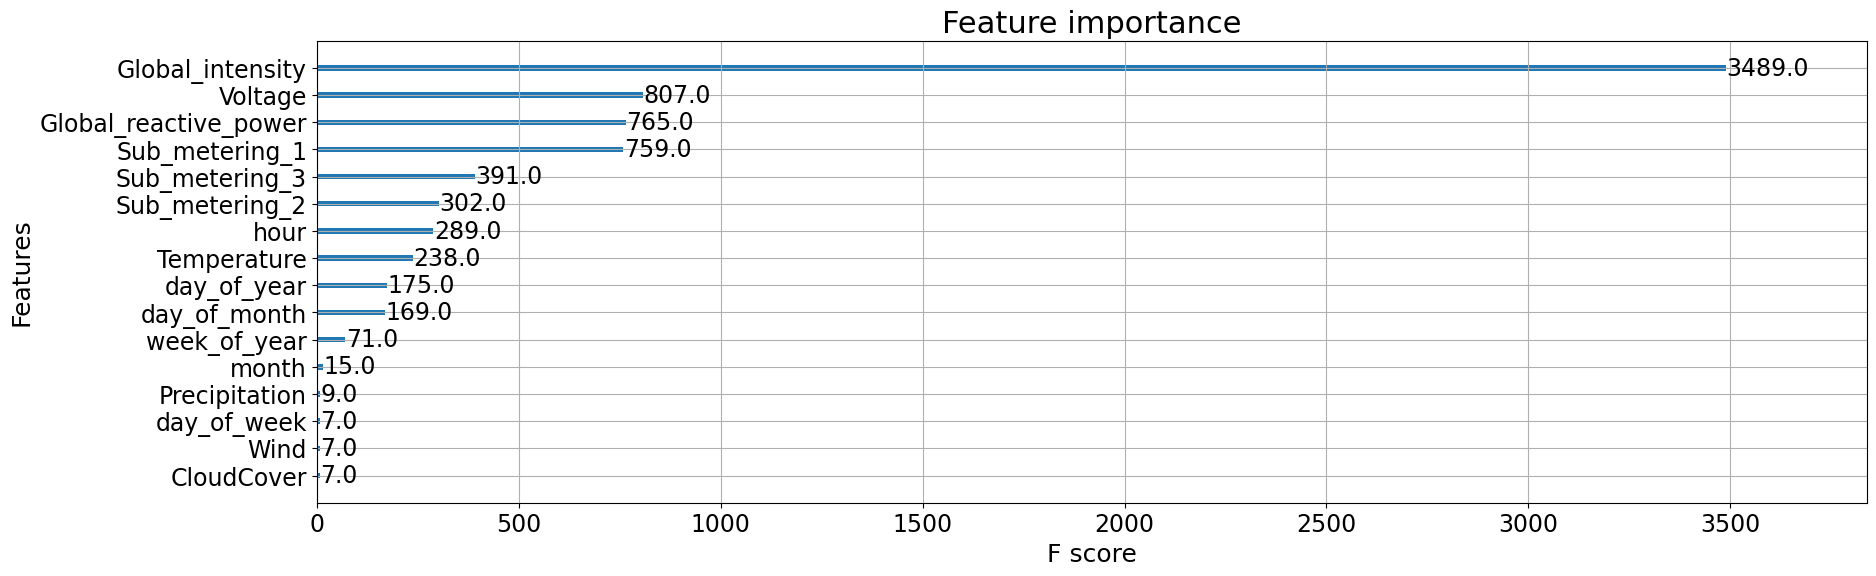

In [30]:
from pylab import rcParams
rcParams['figure.figsize'] = 20, 6 #Changes default matplotlib plots to this size
plot_importance(reg)
plt.show();

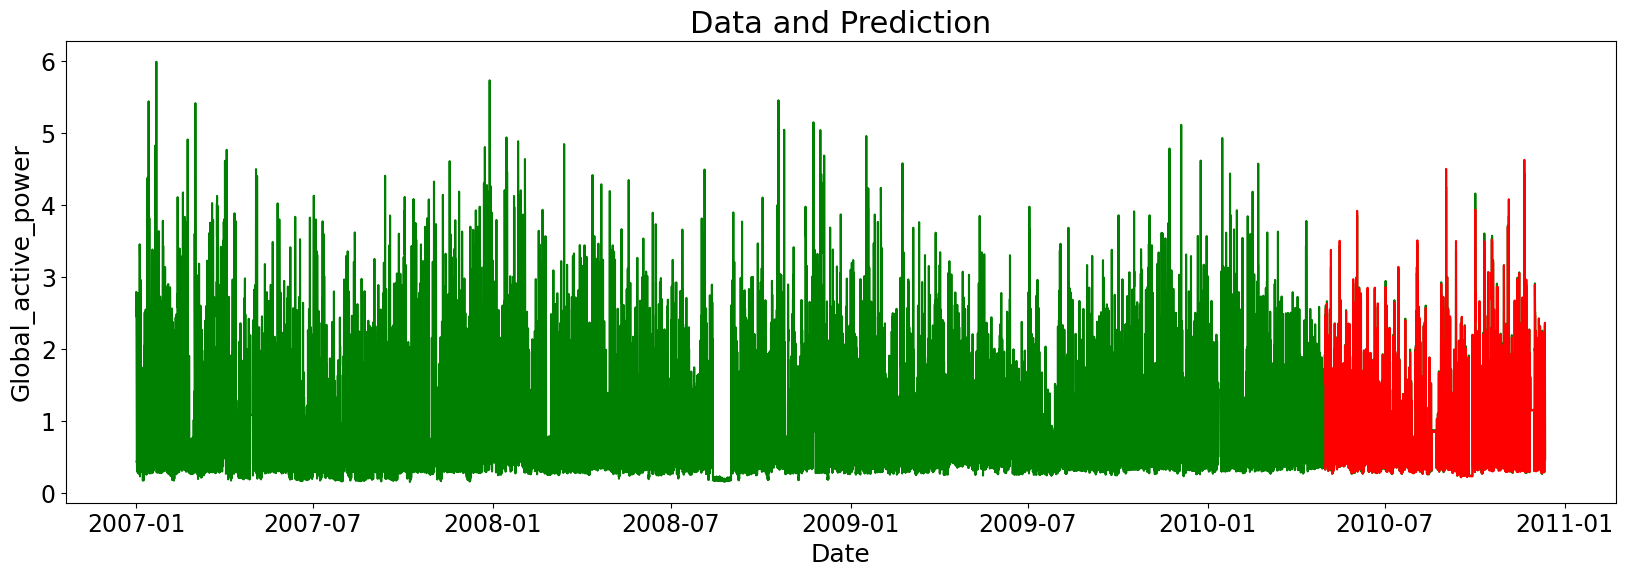

In [31]:
plt.figure(figsize=(20, 6))
sns.lineplot(x= df2.index, y = 'Global_active_power', data=df2, color = 'Green') #test data 
sns.lineplot(x = X_test.index, y = y_preds, color = 'Red') # predictions
plt.title('Data and Prediction')
plt.ylabel('Global_active_power')
plt.xlabel('Date')
plt.show()

In [32]:
test.head(2)

Global_active_power  Global_reactive_power    Voltage  \
Datetime                                                                     
2010-05-01 00:00:00              0.38185               0.092850  245.66875   
2010-05-01 02:00:00              0.35465               0.065533  246.98275   

                     Global_intensity  Sub_metering_1  Sub_metering_2  \
Datetime                                                                
2010-05-01 00:00:00          1.638333             0.0        0.341667   
2010-05-01 02:00:00          1.488333             0.0        0.000000   

                     Sub_metering_3  Precipitation  CloudCover  Temperature  \
Datetime                                                                      
2010-05-01 00:00:00        0.683333            0.0    0.277313     283.3215   
2010-05-01 02:00:00        0.691667            0.0    0.476318     282.9030   

                     Snowfall      Wind  hour  day_of_week  quarter  month  \
Datetime                                                                     
2010-05-01 00:00:00       0.0  1.928284     0            5        2      5   
2010-05-01 02:00:00       0.0  1.785424     2            5        2      5   

                     day_of_month  day_of_year  week_of_year  
Datetime                                                      
2010-05-01 00:00:00             1          121            17  
2010-05-01 02:00:00             1          121            17

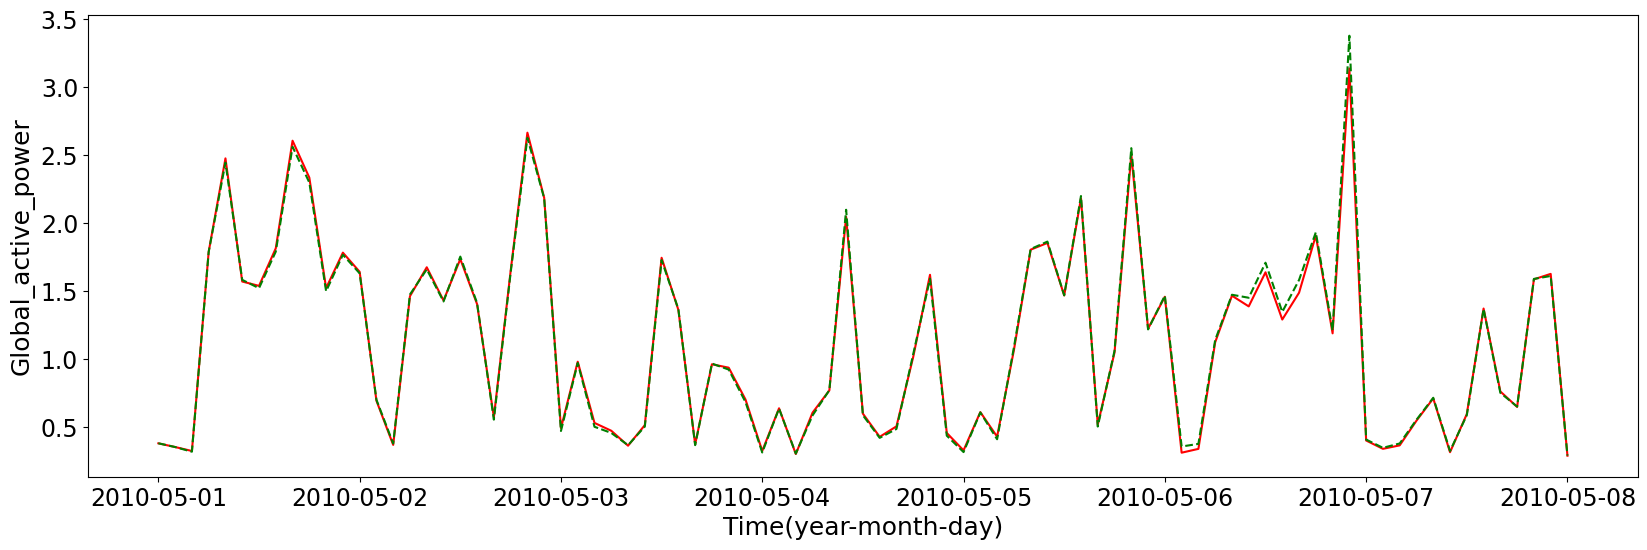

In [33]:
# making a copy of test set
test_copy = test.copy()
# adding predictions to the dataframe
test_copy['predictions'] = y_preds
# slicing a week of the data set
fw = test_copy.loc[(test_copy.index <= '2010-05-08')]

# Plotting
plt.figure(figsize=(20, 6))
sns.lineplot(data = fw, x = fw.index, y='Global_active_power', color = 'Red') # actual values
sns.lineplot(data = fw, x = fw.index, y = 'predictions', color = 'Green', linestyle = 'dashed') # predicted values
plt.ylabel('Global_active_power')
plt.xlabel('Time(year-month-day)')
plt.show()

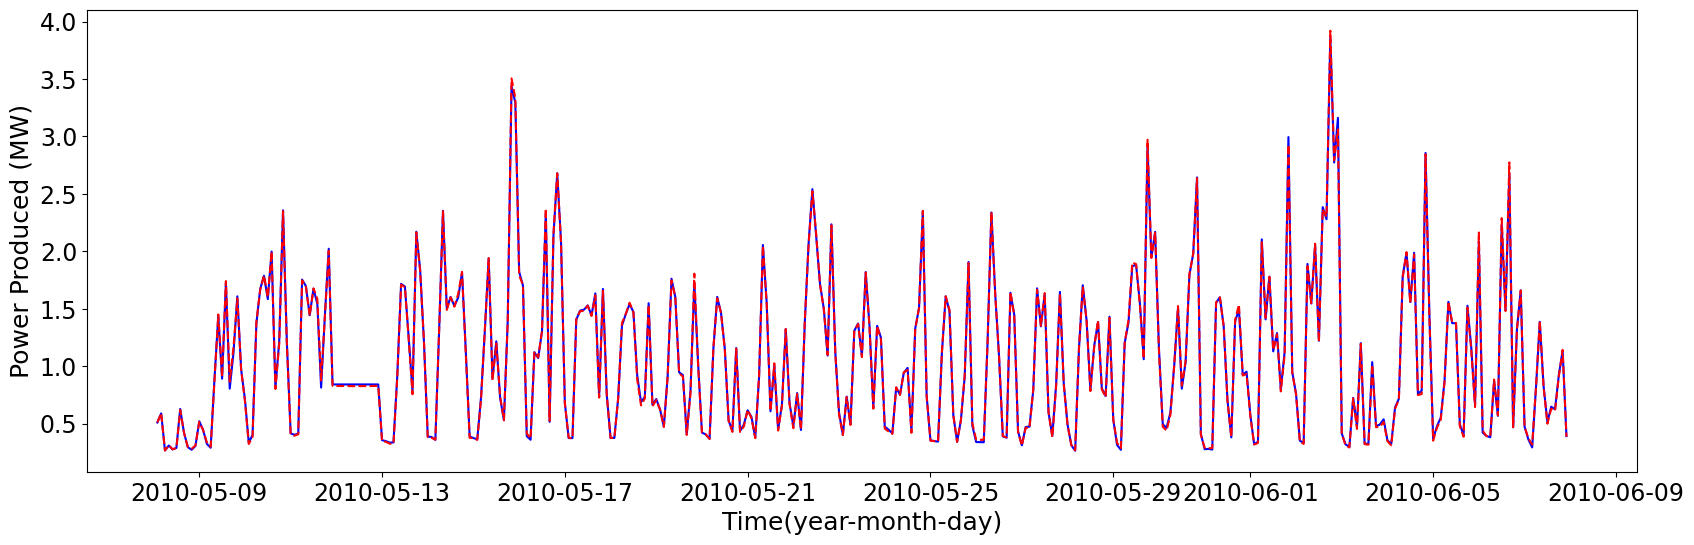

In [34]:
# slicing a week of the data set
fm = test_copy.loc[(test_copy.index > '2010-05-08') & (test_copy.index < '2010-06-08')]
# Plotting
plt.figure(figsize=(20, 6))
sns.lineplot(data = fm, x = fm.index, y='Global_active_power', color = 'blue') # actual values
sns.lineplot(data = fm, x = fm.index, y = 'predictions', color = 'Red', linestyle = 'dashed') # predicted values
plt.ylabel('Power Produced (MW)')
plt.xlabel('Time(year-month-day)')
plt.show()

In [35]:
result = test_copy.loc[(test_copy.index > '2010-05-08') & (test_copy.index < '2010-05-25'), ('Global_active_power', 'predictions')]
result.head(20)

Global_active_power  predictions
Datetime                                             
2010-05-08 02:00:00             0.509483     0.509999
2010-05-08 04:00:00             0.588733     0.590377
2010-05-08 06:00:00             0.265517     0.265720
2010-05-08 08:00:00             0.308883     0.311343
2010-05-08 10:00:00             0.275067     0.276304
2010-05-08 12:00:00             0.288383     0.287734
2010-05-08 14:00:00             0.627283     0.618904
2010-05-08 16:00:00             0.420067     0.419339
2010-05-08 18:00:00             0.294783     0.295637
2010-05-08 20:00:00             0.272100     0.281550
2010-05-08 22:00:00             0.304583     0.308619
2010-05-09 00:00:00             0.520567     0.514374
2010-05-09 02:00:00             0.445550     0.445132
2010-05-09 04:00:00             0.323133     0.335526
2010-05-09 06:00:00             0.289750     0.299735
2010-05-09 08:00:00             0.890783     0.880900
2010-05-09 10:00:00             1.434300     1.449700
2010-05-09 12:00:00             0.891050     0.906567
2010-05-09 14:00:00             1.727650     1.740677
2010-05-09 16:00:00             0.804283     0.865266

In [36]:
result['Error'] = result['Global_active_power'] - result['predictions']
result.head(20)

Global_active_power  predictions     Error
Datetime                                                       
2010-05-08 02:00:00             0.509483     0.509999 -0.000515
2010-05-08 04:00:00             0.588733     0.590377 -0.001643
2010-05-08 06:00:00             0.265517     0.265720 -0.000203
2010-05-08 08:00:00             0.308883     0.311343 -0.002459
2010-05-08 10:00:00             0.275067     0.276304 -0.001237
2010-05-08 12:00:00             0.288383     0.287734  0.000650
2010-05-08 14:00:00             0.627283     0.618904  0.008379
2010-05-08 16:00:00             0.420067     0.419339  0.000728
2010-05-08 18:00:00             0.294783     0.295637 -0.000853
2010-05-08 20:00:00             0.272100     0.281550 -0.009450
2010-05-08 22:00:00             0.304583     0.308619 -0.004036
2010-05-09 00:00:00             0.520567     0.514374  0.006192
2010-05-09 02:00:00             0.445550     0.445132  0.000418
2010-05-09 04:00:00             0.323133     0.335526 -0.012393
2010-05-09 06:00:00             0.289750     0.299735 -0.009985
2010-05-09 08:00:00             0.890783     0.880900  0.009884
2010-05-09 10:00:00             1.434300     1.449700 -0.015400
2010-05-09 12:00:00             0.891050     0.906567 -0.015517
2010-05-09 14:00:00             1.727650     1.740677 -0.013027
2010-05-09 16:00:00             0.804283     0.865266 -0.060983

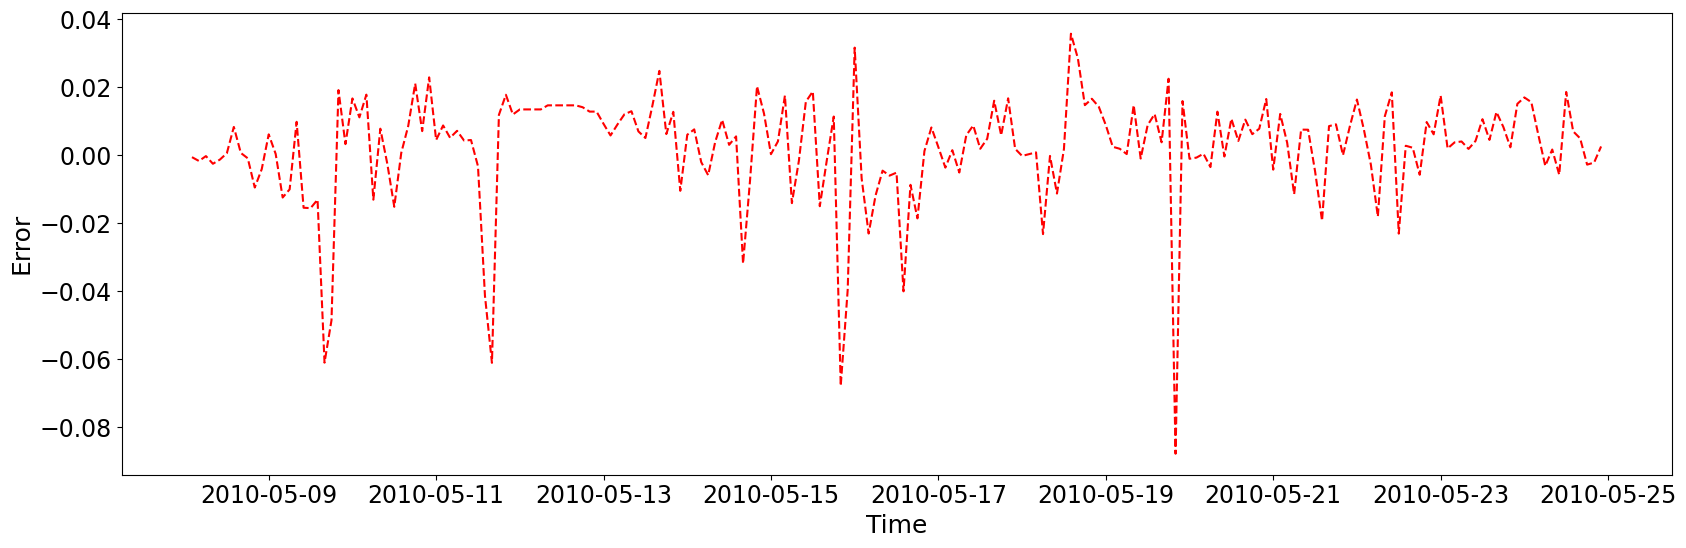

In [37]:
plt.figure(figsize=(20, 6))
sns.lineplot(data = result, x = result.index, y = 'Error', color = 'Red', linestyle = 'dashed') # predicted values
plt.ylabel('Error')
plt.xlabel('Time')
plt.show()

# Anomaly Detection 

In [38]:
df3 = df.copy('Deep')

df3 = df3.rename(columns = {'time' : 'Datetime'})
df3.head()

Datetime  Global_active_power  Global_reactive_power     Voltage  \
0 2007-01-01 00:00:00             2.537017               0.092217  241.228917   
1 2007-01-01 02:00:00             2.562000               0.098383  243.232917   
2 2007-01-01 04:00:00             2.475983               0.094917  242.402417   
3 2007-01-01 06:00:00             2.451500               0.096500  240.768000   
4 2007-01-01 08:00:00             2.793933               0.072850  240.461000   

   Global_intensity  Sub_metering_1  Sub_metering_2  Sub_metering_3  \
0         10.486667             0.0        0.291667        0.000000   
1         10.470000             0.0        0.300000        0.000000   
2         10.130000             0.0        0.291667        0.000000   
3         10.111667             0.0        0.275000        0.000000   
4         11.550000             0.0        0.025000        6.016667   

   Precipitation  CloudCover  Temperature  Snowfall      Wind  
0   1.329846e-07    0.999695    286.43298       0.0  9.663516  
1   2.353721e-07    0.556274    285.98602       0.0  8.988889  
2   3.708734e-09    0.164459    284.50214       0.0  6.604268  
3   0.000000e+00    0.197144    283.30905       0.0  7.486063  
4   2.053049e-08    0.172791    282.31317       0.0  8.071110

In [39]:
df4 = df3[['Datetime','Global_active_power']]

In [40]:
import plotly.express as px

fig = px.line(df4, x= 'Datetime', y= 'Global_active_power', title= 'Global_active_power')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector = dict(
        buttons= list([
            dict(count=1,label='1y', step='year', stepmode='backward'),
            dict(count=2,label='3y', step='year', stepmode='backward'),
            dict(count=3,label='5y', step='year', stepmode='backward'),
            dict(step = 'all')
        ])
    )
)

fig.show()

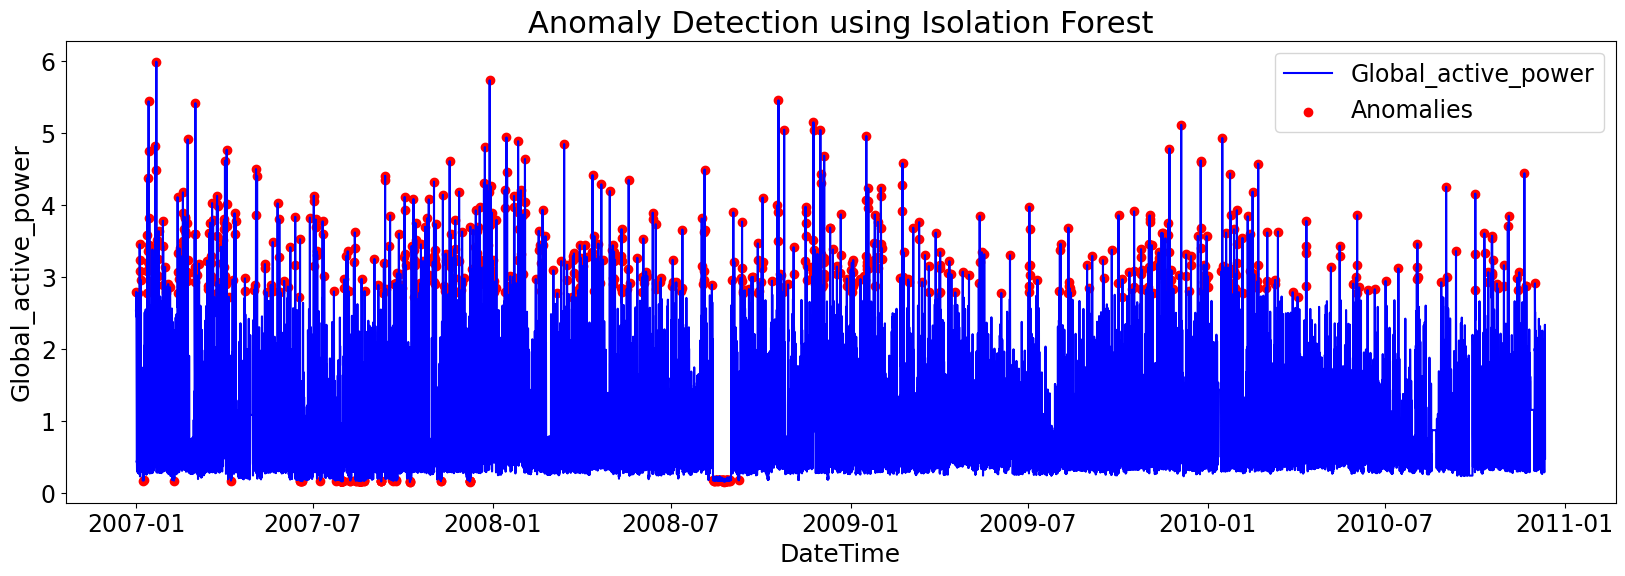

In [41]:
from sklearn.ensemble import IsolationForest

# Preprocessing: Convert 'DateTime' column to datetime format
df4['Datetime'] = pd.to_datetime(df4['Datetime'])

# Feature selection: We'll use only the 'Cost(€/MWh)' column for anomaly detection
X = df4[['Global_active_power']]

# Initialize the Isolation Forest model
model = IsolationForest(contamination=0.05, random_state=42)  # Adjust contamination as needed

# Fit the model
model.fit(X)

# Predict anomalies (1 for normal, -1 for anomalies)
df4['Anomaly'] = model.predict(X)

# Visualize anomalies
plt.figure(figsize=(20, 6))
plt.plot(df4['Datetime'], df4['Global_active_power'], label='Global_active_power',color='Blue')
plt.scatter(df4['Datetime'][df4['Anomaly'] == -1], df4['Global_active_power'][df4['Anomaly'] == -1], color='red', label='Anomalies')
plt.xlabel('DateTime')
plt.ylabel('Global_active_power')
plt.title('Anomaly Detection using Isolation Forest')
plt.legend()
plt.show()

In [42]:
import plotly.express as px

fig = px.line(df4, x= df4['Datetime'], y= 'Global_active_power',color= 'Anomaly', title= 'Global_active_power anomaly detection')

fig.update_xaxes(
    rangeslider_visible=True,
    rangeselector = dict(
        buttons= list([
            dict(count=1,label='1y', step='year', stepmode='backward'),
            dict(count=2,label='3y', step='year', stepmode='backward'),
            dict(count=3,label='5y', step='year', stepmode='backward'),
            dict(count=4,label='7y', step='year', stepmode='backward'),
            dict(step = 'all')
        ])
    )
)

fig.show()